<a href="https://colab.research.google.com/github/gupta24789/Data_Science_Projects/blob/master/colab_notebooks/word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# pip install tensorflow-gpu==2.0.0

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("Tensorflow Version :", tf.__version__)

Tensorflow Version : 2.0.0


## Embedding layer

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

    result = embedding_layer(tf.constant([1,2,3]))
    result.numpy()

results will be the corresponding vector of 1,2 and 3 in embedding matrix




For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape (samples, sequence_length)
The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a (2, 3) input batch and the output is (2, 3, N)

  When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape (samples, sequence_length, embedding_dimensionality).

In [3]:
## List all the datasets in tensorflow
tfds.list_builders()[:3]

['abstract_reasoning', 'aflw2k3d', 'amazon_us_reviews']

In [13]:
## Learning embeddings from scratch

imdb , info = tfds.load("imdb_reviews/subwords8k", with_info = True, as_supervised=True)

In [0]:
train_data, test_data = imdb["train"], imdb["test"]

In [15]:
type(train_data), type(test_data)

(tensorflow.python.data.ops.dataset_ops._OptionsDataset,
 tensorflow.python.data.ops.dataset_ops._OptionsDataset)

In [0]:
## get the encoder 
encoder = info.features['text'].encoder

In [17]:
## "_" represents the space
encoder.subwords[:5]

['the_', ', ', '. ', 'a_', 'and_']

In [0]:
BUFFER_SIZE = 1000
BATCH_SIZE = 10
PADDED_SHAPE = ([None],())

In [0]:
## Following things should be done before modeling
## 1. Shuffle
## 2. Batch
## 3. Length should be same for every input (Padding)

In [0]:
## Method - 1
train_batches = train_data.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes = PADDED_SHAPE)
test_batches = test_data.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE,padded_shapes = PADDED_SHAPE)

In [23]:
next(iter(train_batches))

(<tf.Tensor: id=399, shape=(10, 988), dtype=int64, numpy=
 array([[  12,   56,  393, ...,    0,    0,    0],
        [3075, 8044,   38, ...,    0,    0,    0],
        [  62,    9,    1, ...,    0,    0,    0],
        ...,
        [  62,    9,    1, ...,    0,    0,    0],
        [3943,    4,    9, ...,    0,    0,    0],
        [  12,  129,  909, ...,    0,    0,    0]])>,
 <tf.Tensor: id=400, shape=(10,), dtype=int64, numpy=array([1, 0, 0, 1, 0, 1, 0, 0, 1, 1])>)

In [25]:
## Create Simple Model
embedding_dim = 16

model = tf.keras.models.Sequential([
                tf.keras.layers.Embedding(encoder.vocab_size, embedding_dim),
                tf.keras.layers.GlobalAveragePooling1D(),
                tf.keras.layers.Dense(1,activation = 'sigmoid')                   
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(train_batches, validation_data = test_batches, epochs = 10)

Epoch 1/10
2500/2500 [==============================] - 44s 18ms/step - loss: 0.6376 - accuracy: 0.6904 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
2500/2500 [==============================] - 34s 14ms/step - loss: 0.4661 - accuracy: 0.8383 - val_loss: 0.4241 - val_accuracy: 0.8408
Epoch 3/10
2500/2500 [==============================] - 34s 14ms/step - loss: 0.3626 - accuracy: 0.8780 - val_loss: 0.3674 - val_accuracy: 0.8653
Epoch 4/10
2500/2500 [==============================] - 34s 14ms/step - loss: 0.3092 - accuracy: 0.8966 - val_loss: 0.3366 - val_accuracy: 0.8750
Epoch 5/10
2500/2500 [==============================] - 35s 14ms/step - loss: 0.2762 - accuracy: 0.9076 - val_loss: 0.3227 - val_accuracy: 0.8772
Epoch 6/10
2500/2500 [==============================] - 35s 14ms/step - loss: 0.2497 - accuracy: 0.9164 - val_loss: 0.3156 - val_accuracy: 0.8809
Epoch 7/10
2500/2500 [==============================] - 34s 14ms/step - loss: 0.2333 - accuracy: 0.9221 - val_loss: 

In [26]:
## Get the embedding metrix
embedding_layer = model.layers[0]
embedding_matrix = embedding_layer.get_weights()[0]
print("Shape of embedding matrix :", embedding_matrix.shape)

Shape of embedding matrix : (8185, 16)


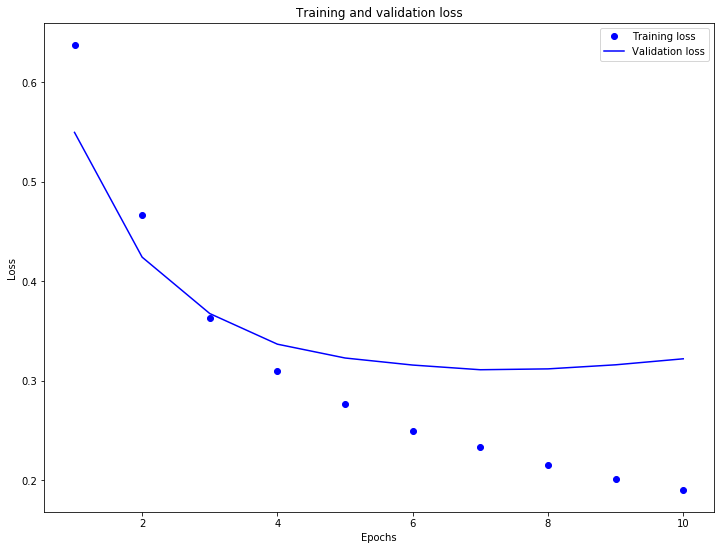

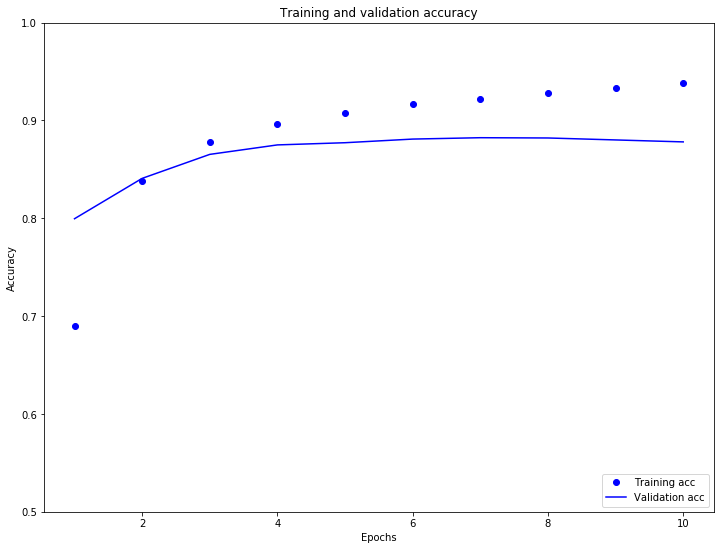

In [27]:
### Plot the loss and accuracy
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [0]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = embedding_matrix[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [0]:
## download files from colab
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [0]:
### Open http://projector.tensorflow.org/ and upload both the files